# REINFORCE tutorial

In [44]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import numpy as np

In [35]:
env = gym.make("CartPole-v1")

lr = 0.01
gamma = 0.99
episodes = 10000

In [36]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        return self.fc(x)

In [45]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy = PolicyNetwork(state_dim, action_dim)
optimizer = optim.Adam(policy.parameters(), lr=lr)

def reinforce():
    all_rewards = []
    for episode in range(episodes):
        state = env.reset()[0]
        log_probs = []
        rewards = []

        while True:
            state = torch.tensor(state, dtype=torch.float32)
            action_probs = policy(state)
            distribution = Categorical(action_probs)
            action = distribution.sample()
            log_probs.append(distribution.log_prob(action))

            next_state, reward, done, _, _ = env.step(action.item())
            rewards.append(reward)
            state = next_state

            if done:
                all_rewards.append(sum(rewards))
                break
        
        discounted_rewards = []
        cumulative_reward = 0
        for r in reversed(rewards):
            cumulative_reward = r + gamma * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)
        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)

        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-8)

        loss = []
        for log_prob, reward in zip(log_probs, discounted_rewards):
            loss.append(- log_prob * reward)
        # print(loss)
        # print(loss.shape)
        loss = torch.tensor(loss, dtype=torch.float32, requires_grad=True).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if episode % 50 == 0:
            print(f"Episode {episode:5}, Total Reward: {sum(rewards):3.1}")
        
    print("Training Complete")

    plt.figure(figsize=(15,5))
    plt.plot(all_rewards)
    means = [all_rewards[0]]
    for i in range(1, len(all_rewards)):
        means.append(np.mean(all_rewards[0:i]))
    plt.plot(means, color="red")
    plt.show()

Episode     0, Total Reward: 2e+01
Episode    50, Total Reward: 1e+01
Episode   100, Total Reward: 3e+01
Episode   150, Total Reward: 2e+01
Episode   200, Total Reward: 2e+01
Episode   250, Total Reward: 2e+01
Episode   300, Total Reward: 2e+01
Episode   350, Total Reward: 2e+01
Episode   400, Total Reward: 2e+01
Episode   450, Total Reward: 1e+01
Episode   500, Total Reward: 3e+01
Episode   550, Total Reward: 2e+01
Episode   600, Total Reward: 1e+01
Episode   650, Total Reward: 2e+01
Episode   700, Total Reward: 2e+01
Episode   750, Total Reward: 2e+01
Episode   800, Total Reward: 2e+01
Episode   850, Total Reward: 1e+01
Episode   900, Total Reward: 2e+01
Episode   950, Total Reward: 4e+01
Episode  1000, Total Reward: 5e+01
Episode  1050, Total Reward: 2e+01
Episode  1100, Total Reward: 4e+01
Episode  1150, Total Reward: 2e+01
Episode  1200, Total Reward: 2e+01
Episode  1250, Total Reward: 1e+01
Episode  1300, Total Reward: 1e+01
Episode  1350, Total Reward: 1e+01
Episode  1400, Total

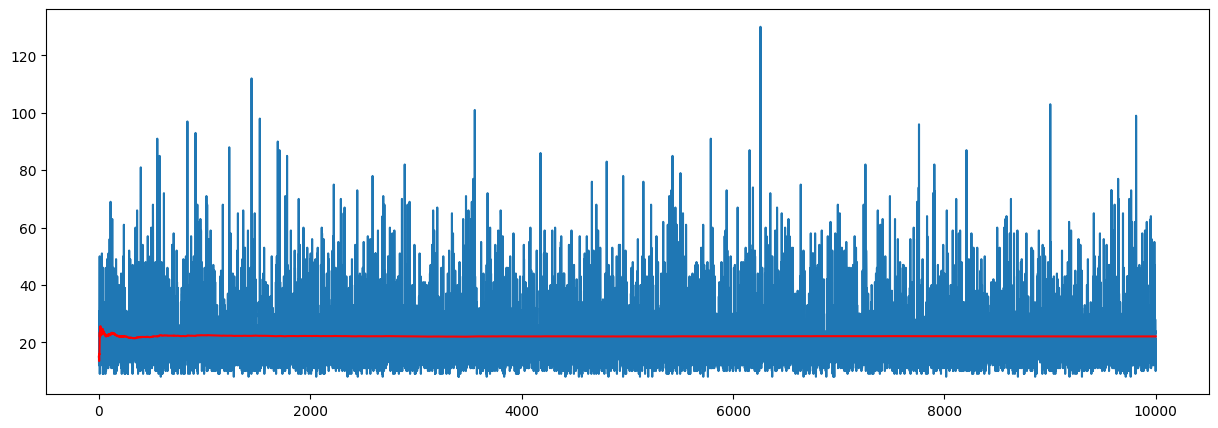

In [46]:
reinforce()

state = env.reset()[0]
done = False
"""
while not done:
    env.render()
    state = torch.tensor(state, dtype=torch.float32)
    action = policy(state).argmax().item()
    state, _, done, _, _ = env.step(action)
"""
env.close()